In [23]:
%matplotlib inline
import os
import sys
import random
sys.path.append('../midi')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [24]:
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# DataLoader

In [25]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Pressed notes are replaced by 1
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
        
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll

    return padded_piano_roll


class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # Shifting by one time step
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifting by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # padding sequence so that all of them have the same length
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,max_length=self.longest_sequence_length,pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),torch.LongTensor(ground_truth_sequence_padded),torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [26]:
trainset = NotesGenerationDataset('./musictraining/ABBA/onesong', longest_sequence_length=None)

trainset_loader = data.DataLoader(trainset, batch_size=1,shuffle=True, drop_last=True)

In [27]:
X = next(iter(trainset_loader))
X[0].shape

torch.Size([1, 953, 88])

In [28]:
valset = NotesGenerationDataset('./musictraining/ABBA/onesong', longest_sequence_length=None)

valset_loader = data.DataLoader(valset, batch_size=1, shuffle=False, drop_last=False)

In [29]:
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([1, 953, 88])

# RNN

In [30]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.gru(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [31]:
model = RNN(input_size=88, hidden_size=128, num_classes=88).cuda()

criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss().cuda()

In [32]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [11]:
validate(model)

1.4591337422818242e-05

In [43]:
a=np.linspace(1,10,3)
b=np.linspace(3,15,3)
c=np.linspace(4,50,3)
np.hstack([a,b[1:],c])[0]

1.0

In [33]:
clip = 1.0
best_val_loss = float("inf")
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, 3)
    down = np.linspace(lr_high, lr_mid, 3)
    floor = np.linspace(lr_mid, lr_low, 3)
    return np.hstack([up, down[1:], floor])

In [34]:
def train_model(model, lrs_triangular, epochs_number=2, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for lr, batch in zip(lrs_triangular, trainset_loader):
            optimizer.param_groups[0]['lr'] = lr

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'best.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [36]:
rnn = RNN(input_size=88, hidden_size=128, num_classes=88)
rnn = rnn.cuda()
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular)
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss)
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 1.370887279510498
Validation Loss: Epoch: 0 : 1.4410410403658908e-05

Training Loss: Epoch: 1 : 1.2993085384368896
Validation Loss: Epoch: 1 : 1.422472645345765e-05

Training Loss: Epoch: 0 : 1.2456210851669312
Validation Loss: Epoch: 0 : 1.40991266831084e-05

Training Loss: Epoch: 1 : 1.2042018175125122
Validation Loss: Epoch: 1 : 1.3978094591085377e-05

Training Loss: Epoch: 0 : 1.183340311050415
Validation Loss: Epoch: 0 : 1.392749012245123e-05

Training Loss: Epoch: 1 : 1.1789964437484741
Validation Loss: Epoch: 1 : 1.3886452165152665e-05



In [37]:
rnn.load_state_dict(torch.load('best.pth'))

<All keys matched successfully>

# Validation

In [38]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

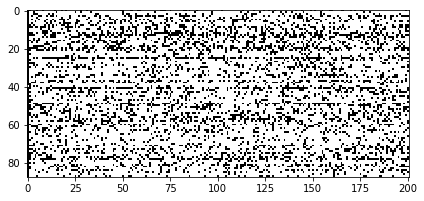

In [39]:
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite('sample.mid', sample.transpose(), dt=0.3)

In [40]:
FileLink('sample.mid')

/home/jovyan/Music-Generation/notebooks/sample.mid